In [47]:
import re
import os
import pickle
from tqdm import tqdm
import itertools

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)

import seaborn as sns
import matplotlib.font_manager as fm
from matplotlib import rc
import matplotlib.pyplot as plt
plt.rc('font', family = 'Malgun Gothic')
plt.rc('axes', unicode_minus=False)

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

import warnings
warnings.filterwarnings('ignore')

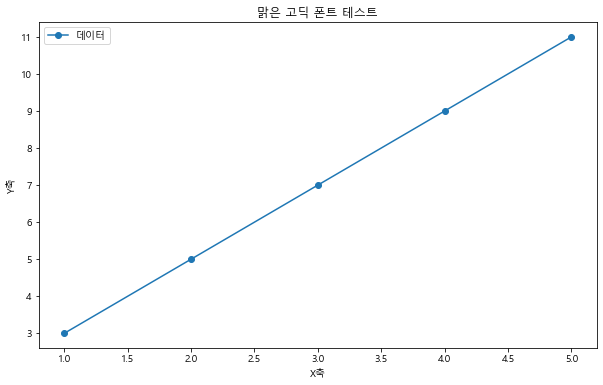

In [2]:
x = [1, 2, 3, 4, 5]
y = [3, 5, 7, 9, 11]

plt.figure(figsize=(10,6))
plt.plot(x, y, 'o-', label="데이터")
plt.title("맑은 고딕 폰트 테스트")
plt.xlabel("X축")
plt.ylabel("Y축")
plt.legend()
plt.show()

In [3]:
clustered_raw = pd.read_excel("./data/clustered_raw(주종+Cluster).xlsx")
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Retailer,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,A,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,B,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,A,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,A,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,A,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,A,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,A,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,A,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN


# Liquor - Liquor

In [94]:
def getBasket(df, col) :
    raw_exploded = df[["OrderId", col]]
    raw_onehot = pd.get_dummies(raw_exploded, columns=[col], prefix='', prefix_sep='')
    raw_onehot = raw_onehot.groupby("OrderId").sum()
    raw_onehot = raw_onehot.clip(upper = 1)
    
    # Apriori 알고리즘을 사용하여 빈번한 항목 집합 찾기
    frequent_itemsets = apriori(raw_onehot, min_support=0.01, use_colnames=True)  # min_support는 임의로 설정한 값입니다. 필요에 따라 조정하십시오.
    # 연관 규칙 생성
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    # Lift 값으로 정렬하여 상위 규칙 확인
    rules = rules.sort_values(['lift'], ascending=False)
    
    return rules

In [99]:
for c in range(6) :
    c_raw = clustered_raw[clustered_raw.Cluster == c]
    liq_ids = np.unique(c_raw[c_raw.Category2 == "주류"].OrderId).tolist()
    c_raw = c_raw[c_raw.OrderId.isin(liq_ids)]
    print("============================================")
    print(f" * 클러스터 {c}")
    print(getBasket(c_raw, "LiquorCategory"))
    print()

 * 클러스터 0
  antecedents consequents  antecedent support  consequent support   support  \
3      (수입맥주)   (수입맥주혼성주)            0.171233            0.030822  0.013699   
2   (수입맥주혼성주)      (수입맥주)            0.030822            0.171233  0.013699   
0        (탁주)        (소주)            0.023973            0.376712  0.010274   
1        (소주)        (탁주)            0.376712            0.023973  0.010274   

   confidence      lift  leverage  conviction  zhangs_metric  
3    0.080000  2.595556  0.008421    1.053454       0.741736  
2    0.444444  2.595556  0.008421    1.491781       0.634276  
0    0.428571  1.137662  0.001243    1.090753       0.123977  
1    0.027273  1.137662  0.001243    1.003393       0.194139  

 * 클러스터 1
        antecedents      consequents  antecedent support  consequent support  \
9         (수입맥주혼성주)       (맥주, 수입맥주)            0.049296            0.058685   
8        (맥주, 수입맥주)        (수입맥주혼성주)            0.058685            0.049296   
6     (수입맥주혼성주, 맥주)         

In [105]:
for c in range(6):
    c_raw = clustered_raw[clustered_raw.Cluster == c]
    liq_ids = np.unique(c_raw[c_raw.Category2 == "주류"].OrderId).tolist()
    c_raw = c_raw[c_raw.OrderId.isin(liq_ids)]
    
    rules = getBasket(c_raw, "LiquorCategory")
    
    print("============================================")
    print(f"Cluster {c}")
    
    max_i = 4  # 원하는 규칙의 수를 설정합니다. 여기서는 상위 5개의 규칙만 출력하도록 설정했습니다.
    for i, row in rules.head(max_i + 1).iterrows():
        antecedent = list(row['antecedents'])[0]
        consequent = list(row['consequents'])[0]
        
        print(f"Rule: {antecedent} => {consequent}")
        print(f"Support: {round(row['support'], 2)}")
        print(f"Confidence: {round(row['confidence'], 2)}")
        print(f"Lift: {round(row['lift'], 2)}")
        print("------------------------------------")
    print()

Cluster 0
Rule: 수입맥주 => 수입맥주혼성주
Support: 0.01
Confidence: 0.08
Lift: 2.6
------------------------------------
Rule: 수입맥주혼성주 => 수입맥주
Support: 0.01
Confidence: 0.44
Lift: 2.6
------------------------------------
Rule: 탁주 => 소주
Support: 0.01
Confidence: 0.43
Lift: 1.14
------------------------------------
Rule: 소주 => 탁주
Support: 0.01
Confidence: 0.03
Lift: 1.14
------------------------------------

Cluster 1
Rule: 수입맥주혼성주 => 맥주
Support: 0.01
Confidence: 0.29
Lift: 4.87
------------------------------------
Rule: 맥주 => 수입맥주혼성주
Support: 0.01
Confidence: 0.24
Lift: 4.87
------------------------------------
Rule: 수입맥주혼성주 => 수입맥주
Support: 0.01
Confidence: 0.6
Lift: 4.06
------------------------------------
Rule: 수입맥주 => 수입맥주혼성주
Support: 0.01
Confidence: 0.1
Lift: 4.06
------------------------------------
Rule: 수입맥주혼성주 => 수입맥주
Support: 0.02
Confidence: 0.38
Lift: 2.58
------------------------------------

Cluster 2
Rule: 과실주 => 맥주
Support: 0.01
Confidence: 1.0
Lift: 3.24
------------------------

### 해설

##### 지표
* antecedents: 조건절 (예: 고객이 이 항목을 구매했을 때)
* consequents: 결과절 (예: 고객이 이 항목도 구매할 확률이 높다)
* antecedent support: 조건절 항목의 지지도 (전체 거래 중 해당 항목이 포함된 비율)
* consequent support: 결과절 항목의 지지도
* support: 조건절과 결과절 항목이 함께 발생한 거래의 비율
* confidence: 조건절이 주어졌을 때 결과절 항목도 구매될 확률
* lift: 연관 규칙의 신뢰도를 평가하는 지표. 1보다 큰 값은 항목 간의 양의 관계를, 1보다 작은 값은 음의 관계를 나타낸다.
* leverage: 조건절과 결과절의 독립성을 평가하는 지표. 0은 완전히 독립을 의미하며, 0보다 크거나 작은 값은 항목 간의 양의 또는 음의 관계를 나타낸다.
* conviction: 조건절이 주어졌을 때 결과절 항목이 구매되지 않을 확률. 큰 값은 항목 간의 강한 양의 관계를 나타낸다.
* zhangs_metric: 연관 규칙의 강도를 측정하는 지표. -1과 1 사이의 값으로, 0은 독립을, 1은 완전한 양의 관계를, -1은 완전한 음의 관계를 나타낸다.

##### 결과 해석
* 클러스터 0:
수입맥주와 수입맥주혼성주 간에는 높은 향상도(lift) 값을 가지며, 둘 사이의 연관성이 크다는 것을 나타냅니다.
탁주와 소주도 연관성이 있지만, 수입맥주와 수입맥주혼성주만큼 강력하지 않습니다.

* 클러스터 1:
맥주와 수입맥주, 수입맥주혼성주와 맥주의 조합이 주로 나타나며, 특히 수입맥주혼성주와 맥주, 수입맥주의 조합은 높은 향상도 값을 보입니다.

* 클러스터 2:
과실주와 맥주, 과실주와 수입맥주의 연결이 강하게 나타납니다. 과실주는 수입맥주나 맥주와 함께 구매될 가능성이 높습니다.

* 클러스터 3:
수입맥주와 과실주 간의 연관성이 주로 나타나며, 소주와 맥주, 수입맥주의 조합도 보입니다.

* 클러스터 4:
수입맥주와 수입맥주혼성주 간의 연결이 주로 나타나며, 이 둘은 강력한 연관성을 가집니다.

### 해설2
각 클러스터에서 얻어진 연관 규칙의 해석은 주로 Lift 값과 Confidence 값을 통해 이루어집니다. 여기서:

* Lift: 두 항목 A와 B의 동시 출현이 얼마나 흥미로운지를 나타내는 지표입니다. Lift가 1보다 크면 A와 B가 함께 구매될 확률이 높다는 것을 의미하며, 1보다 작으면 함께 구매될 확률이 낮다는 것을 의미합니다. Lift 값이 1이면 두 항목은 독립적입니다.

* Confidence: A가 주어졌을 때 B를 구매할 확률을 나타냅니다.

---

* Cluster 0:
수입맥주를 구매하는 고객은 수입맥주혼성주를 구매할 확률이 높다. 반대의 경우도 마찬가지다. Lift 값이 2.6인 것은 두 항목이 동시에 구매될 가능성이 높다는 것을 나타낸다.
탁주를 구매하는 고객들도 소주를 구매하는 경향이 있다.

* Cluster 1:
맥주를 구매하는 고객들은 수입맥주혼성주를 구매할 가능성이 매우 높으며, 반대의 경우도 동일하다.
수입맥주와 수입맥주혼성주도 자주 함께 구매된다.

* Cluster 2:
과실주를 구매하는 고객들은 맥주나 수입맥주도 함께 구매하는 경향이 있다.
특히, 과실주와 맥주의 조합이 높은 Lift 값을 보이므로, 이들이 함께 구매될 가능성이 매우 높다.

* Cluster 3:
수입맥주와 과실주, 그리고 맥주와 소주의 조합이 주로 보인다.
맥주와 소주의 조합의 경우, 소주를 구매하는 고객 중 많은 비율이 맥주도 함께 구매한다.

* Cluster 4:
수입맥주와 수입맥주혼성주가 함께 구매되는 경향이 있다.

* Cluster 5:
과실주와 수입맥주의 조합이 주로 나타나며, 함께 구매될 가능성이 있다.

# Liquor - Others

In [111]:
clustered_raw["New_Label"] = clustered_raw["Category3"]
clustered_raw.loc[~clustered_raw.LiquorCategory.isna(), "New_Label"] = clustered_raw.loc[~clustered_raw.LiquorCategory.isna(), "LiquorCategory"]
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory,New_Label
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN,어육제품류
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN,즉석/조리식품
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN,드레싱/소스
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN,장류
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN,장류
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN,요구르트
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN,라면류
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN,농산물통조림/병
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN,사탕류


In [115]:
clustered_raw

,id,OrderId,PersonId,PurchaseDate,ItemDescription,SalesUnit,Price,ProductCode,MasterCategoryFullName,Agegroup,...,Category1,Category2,Category3,Category4,Category5,Sales,Cluster,요일,LiquorCategory,New_Label
0,2,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,대림 오양맛살270g,1,1480,8801088106118,가공식품-어육/연식품류-어육제품류-맛살,36,...,가공식품,어육/연식품류,어육제품류,맛살,NaN,1480,NaN,목,NaN,어육제품류
1,8,2021010108138430000000,168586e3815732f18f68ddef204819c7,2021-01-01,풀무원 김치뚝배기 우동 (2인),1,6180,8801114147252,가공식품-즉석/편의식품-즉석/조리식품-즉석면류,36,...,가공식품,즉석/편의식품,즉석/조리식품,즉석면류,NaN,6180,2.0,금,NaN,즉석/조리식품
2,9,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,CJ백설소갈비양념500g,1,2580,8801007176352,가공식품-조미료-드레싱/소스-소스,36,...,가공식품,조미료,드레싱/소스,소스,NaN,2580,NaN,목,NaN,드레싱/소스
3,11,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장조림볶음용,2,8880,8801005104067,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,17760,NaN,목,NaN,장류
4,13,2021021108716080000000,a55a071126dd47d5414773bfc8a06c09,2021-02-11,샘표맛간장국찌개1.8L,1,8900,8801005110228,가공식품-조미료-장류-간장,36,...,가공식품,조미료,장류,간장,NaN,8900,NaN,목,NaN,장류
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118804,390581,2021040306718280000000,eea4022e52f88e47e002bf9533aded5c,2021-04-03,빙그레 요플레 클래식,1,2800,8801104280037,가공식품-유제품-요구르트-기타요구르트,40,...,가공식품,유제품,요구르트,기타요구르트,NaN,2800,4.0,토,NaN,요구르트
118805,390584,2021022700263890000000,eea4022e52f88e47e002bf9533aded5c,2021-02-27,풀무원 자연은맛있다,1,4980,8801114150450,가공식품-즉석/편의식품-라면류-봉지라면,40,...,가공식품,즉석/편의식품,라면류,봉지라면,NaN,4980,4.0,토,NaN,라면류
118806,390586,2023062500967460000000,22aca1bdf92346d1fbd589fd72622957,2023-06-25,딸기잼800g,1,5880,8809306211033,가공식품-통조림/병-농산물통조림/병-잼류/스프레드류,44,...,가공식품,통조림/병,농산물통조림/병,잼류/스프레드류,NaN,5880,5.0,일,NaN,농산물통조림/병
118807,390588,2023062905029460000000,5957cbf9d746b210eedc703ea368a00e,2023-06-29,왓따산리오캐릭터즈13,2,500,8801062874781,가공식품-과자류-사탕류-껌류,36,...,가공식품,과자류,사탕류,껌류,NaN,1000,1.0,목,NaN,사탕류


In [116]:
def getBasket(df, col) :
    raw_exploded = df[["OrderId", col]]
    raw_onehot = pd.get_dummies(raw_exploded, columns=[col], prefix='', prefix_sep='')
    raw_onehot = raw_onehot.groupby("OrderId").sum()
    raw_onehot = raw_onehot.clip(upper = 1)
    
    # Apriori 알고리즘을 사용하여 빈번한 항목 집합 찾기
    frequent_itemsets = apriori(raw_onehot, min_support=0.01, use_colnames=True)  # min_support는 임의로 설정한 값입니다. 필요에 따라 조정하십시오.
    # 연관 규칙 생성
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
    # Lift 값으로 정렬하여 상위 규칙 확인
    rules = rules.sort_values(['lift'], ascending=False)
    
    return rules

In [123]:
liq_cats = ['고량주', '과실주', '과실주스파클링', '과실주혼성주', '기타주류', '기타주류혼성주', '기타증류주',
       '리큐르', '맥주', '맥주라이트', '민속주/전통주', '민속주/전통주차례주', '민속주/전통주혼성주', '보드카',
       '보드카혼성주', '샴페인', '소주', '소주담금주', '소주혼성주', '수입맥주', '수입맥주논알콜',
       '수입맥주혼성주', '약주', '약주차례주', '약주혼성주', '와인', '위스키', '진/럼/데킬라/아쿠아비트',
       '청주', '탁주', '탁주유산균', '탁주혼성주']

for c in range(6) :
    c_raw = clustered_raw[clustered_raw.Cluster == c]
    print("============================================")
    print(f" * 클러스터 {c}")
    rules = getBasket(c_raw, "New_Label")
    # 주류 카테고리에 포함된 항목만 필터링
    filtered_rules = rules[rules['antecedents'].apply(lambda x: any(item for item in x if item in liq_cats)) | 
                           rules['consequents'].apply(lambda x: any(item for item in x if item in liq_cats))]
    print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])
    print()

 * 클러스터 0
          antecedents       consequents   support  confidence      lift
90               (맥주)            (수입맥주)  0.011244    0.146789  4.177615
91             (수입맥주)              (맥주)  0.011244    0.320000  4.177615
89               (맥주)              (소주)  0.018271    0.238532  3.085738
88               (소주)              (맥주)  0.018271    0.236364  3.085738
156  (햄/소시지(통조림/병제외))              (소주)  0.011244    0.139130  1.799842
157              (소주)  (햄/소시지(통조림/병제외))  0.011244    0.145455  1.799842
93               (맥주)             (연식품)  0.011947    0.155963  1.668690
92              (연식품)              (맥주)  0.011947    0.127820  1.668690
60              (라면류)              (소주)  0.023893    0.115254  1.490971
61               (소주)             (라면류)  0.023893    0.309091  1.490971
63             (수입맥주)             (라면류)  0.010541    0.300000  1.447119
62              (라면류)            (수입맥주)  0.010541    0.050847  1.447119
94          (즉석/조리식품)              (맥주)  0.014758    0

In [124]:
liq_cats = ['고량주', '과실주', '과실주스파클링', '과실주혼성주', '기타주류', '기타주류혼성주', '기타증류주',
       '리큐르', '맥주', '맥주라이트', '민속주/전통주', '민속주/전통주차례주', '민속주/전통주혼성주', '보드카',
       '보드카혼성주', '샴페인', '소주', '소주담금주', '소주혼성주', '수입맥주', '수입맥주논알콜',
       '수입맥주혼성주', '약주', '약주차례주', '약주혼성주', '와인', '위스키', '진/럼/데킬라/아쿠아비트',
       '청주', '탁주', '탁주유산균', '탁주혼성주']

for c in range(6):
    c_raw = clustered_raw[clustered_raw.Cluster == c]
    print("============================================")
    print(f" * 클러스터 {c}")
    
    rules = getBasket(c_raw, "New_Label")
    filtered_rules = rules[rules['antecedents'].apply(lambda x: any(item for item in x if item in liq_cats)) | 
                           rules['consequents'].apply(lambda x: any(item for item in x if item in liq_cats))]
    
    for _, row in filtered_rules.iterrows():
        antecedent = ", ".join(list(row['antecedents']))
        consequent = ", ".join(list(row['consequents']))
        
        print(f"Rule: {antecedent} => {consequent}")
        print(f"Support: {round(row['support'], 2)}")
        print(f"Confidence: {round(row['confidence'], 2)}")
        print(f"Lift: {round(row['lift'], 2)}")
        print("------------------------------------")
    print()

 * 클러스터 0
Rule: 맥주 => 수입맥주
Support: 0.01
Confidence: 0.15
Lift: 4.18
------------------------------------
Rule: 수입맥주 => 맥주
Support: 0.01
Confidence: 0.32
Lift: 4.18
------------------------------------
Rule: 맥주 => 소주
Support: 0.02
Confidence: 0.24
Lift: 3.09
------------------------------------
Rule: 소주 => 맥주
Support: 0.02
Confidence: 0.24
Lift: 3.09
------------------------------------
Rule: 햄/소시지(통조림/병제외) => 소주
Support: 0.01
Confidence: 0.14
Lift: 1.8
------------------------------------
Rule: 소주 => 햄/소시지(통조림/병제외)
Support: 0.01
Confidence: 0.15
Lift: 1.8
------------------------------------
Rule: 맥주 => 연식품
Support: 0.01
Confidence: 0.16
Lift: 1.67
------------------------------------
Rule: 연식품 => 맥주
Support: 0.01
Confidence: 0.13
Lift: 1.67
------------------------------------
Rule: 라면류 => 소주
Support: 0.02
Confidence: 0.12
Lift: 1.49
------------------------------------
Rule: 소주 => 라면류
Support: 0.02
Confidence: 0.31
Lift: 1.49
------------------------------------
Rule: 수입맥주 => 라면류
Su